In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        out,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            elif upsampling_layer > num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens // 2, out)
            else:
                raise ValueError(
                    f"Invalid upsampling layer: {upsampling_layer}. In Encoder."
                )

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return F.sigmoid(x_recon)


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
            out_channels,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = (
            self.quantize(x)
        )
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
            "encoding_indices": encoding_indices,
        }


class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        sample_size=64,
        in_channels=1,
        out_channels=1,
        num_hiddens=64,
        num_downsampling_layers=2,
        num_residual_layers=2,
        num_residual_hiddens=128,
        embedding_dim=4,  # 32, 64, 128, 256
        num_embeddings=64,  # 256, 512, 1024, 2048
        use_ema=True,
        decay=0.99,
        epsilon=1e-5,
        beta=0.25,
        lr=2e-4,
        weight_decay=0.0,
        fid_features=2048,
        batch_size=64,  # 128
        dataset="celeba_hq",
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=in_channels,
            out_channels=out_channels,
            num_hiddens=num_hiddens,
            num_downsampling_layers=num_downsampling_layers,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            use_ema=use_ema,
            decay=decay,
            epsilon=epsilon,
        )

        self.beta = beta
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("train_dictionary_loss", out["dictionary_loss"])

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("val_dictionary_loss", out["dictionary_loss"])

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            if self.global_step == 0 and batch_idx == 0:
                self.logger.experiment.log(
                    {
                        "original": wandb.Image(
                            torchvision.utils.make_grid(x[:64], nrow=8),
                            caption="Real Image",
                        )
                    }
                )

            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"][:64], nrow=8),
                        caption=f"Step {self.global_step}",
                    )
                }
            )

    def on_test_start(self):
        self.fid = FrechetInceptionDistance(self.hparams.fid_features).cpu()

    def test_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        # Resize to 299x299
        x = F.interpolate(x, size=299)
        x_hat = F.interpolate(out["x_recon"], size=299)

        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        # Convert to uint8
        x = (x * 255).to(torch.uint8).cpu()
        x_hat = (x_hat * 255).to(torch.uint8).cpu()

        # Compute FID
        self.fid.update(x, real=True)
        self.fid.update(x_hat, real=False)

        fid_score = self.fid.compute()
        self.log("fid_score", fid_score)

    def configure_optimizers(self):
        return optim.Adam(
            self.model.parameters(),
            lr=self.hparams.lr,
            amsgrad=True,
            weight_decay=self.hparams.weight_decay,
        )

    def train_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    (
                        torchvision.transforms.Grayscale()
                        if self.hparams.in_channels == 1
                        else torchvision.transforms.Lambda(lambda x: x)
                    ),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/train", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def val_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def test_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 4))

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )


In [18]:
vqvae = VQVAE_Trainer.load_from_checkpoint("vqvae/logs/vq-vae/o8cxx8bp/checkpoints/epoch=9-step=9380.ckpt")
model = vqvae.model.to("mps")

In [19]:
# Print codebookshape
print(model.vq.e_i_ts.shape)

torch.Size([4, 16])


In [20]:
train_loader = vqvae.train_dataloader()
val_loader = vqvae.val_dataloader()

In [21]:
with torch.no_grad():
    model.eval()
    classes = []
    idxs = []

    for x, y in tqdm.tqdm(train_loader):    
        x = x.to("mps")

        out = model.quantize(x)[3]
        
        classes.extend(y.tolist())
        idxs.extend(out.tolist())
        
    classes = torch.tensor(classes)
    idxs = torch.tensor(idxs)

    print(classes.shape)
    print(idxs.shape)

    # Convert to int dataset and save
    dataset = torch.utils.data.TensorDataset(idxs, classes)
    # torch.save(dataset, "projects/custom/vq-vae/train_z_embed.pt")

100%|██████████| 938/938 [00:05<00:00, 170.68it/s]


torch.Size([60000])
torch.Size([60000, 64])


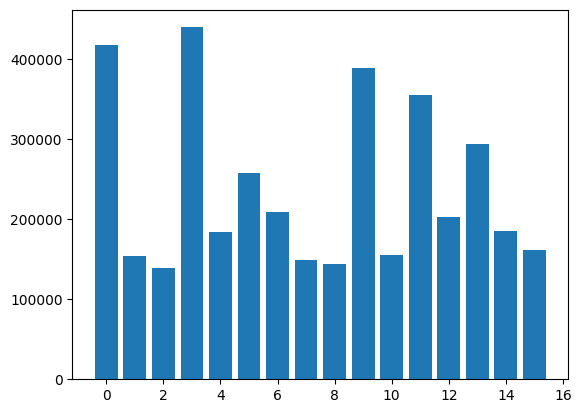

In [22]:
# train
# Plot distribution of indices
import matplotlib.pyplot as plt

counts = torch.bincount(idxs.flatten())
plt.bar(range(len(counts)), counts)
plt.show()

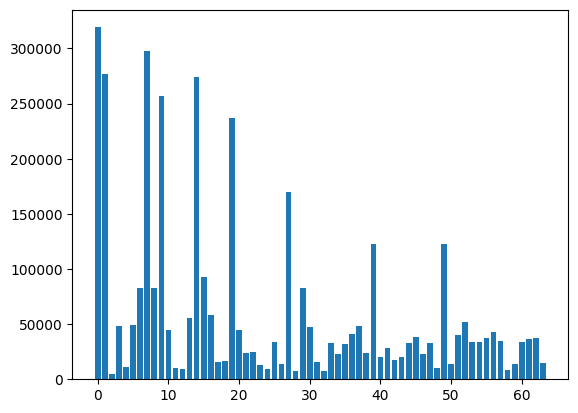

In [11]:
# train
# Plot distribution of indices
import matplotlib.pyplot as plt

counts = torch.bincount(idxs.flatten())
plt.bar(range(len(counts)), counts)
plt.show()

In [16]:
with torch.no_grad():
    model.eval()
    classes = []
    idxs = []

    for x, y in tqdm.tqdm(val_loader):    
        x = x.to("mps")

        out = model.quantize(x)[3]
        
        classes.extend(y.tolist())
        idxs.extend(out.tolist())
        
    classes = torch.tensor(classes)
    idxs = torch.tensor(idxs)

    print(classes.shape)
    print(idxs.shape)

    # Convert to int dataset and save
    dataset = torch.utils.data.TensorDataset(idxs, classes)
    # torch.save(dataset, "projects/custom/vq-vae/val_z_embed.pt")

100%|██████████| 157/157 [00:00<00:00, 186.05it/s]

torch.Size([10000])
torch.Size([10000, 64])


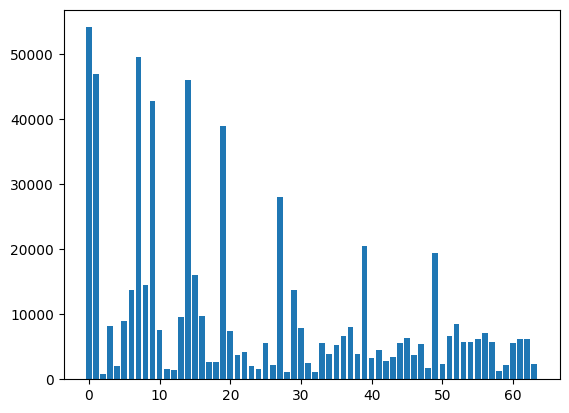

In [17]:
# val
# Plot distribution of indices
import matplotlib.pyplot as plt

counts = torch.bincount(idxs.flatten())
plt.bar(range(len(counts)), counts)
plt.show()

In [ ]:
# Train Loader
train_loader = torch.utils.data.DataLoader(
    torch.load("projects/custom/vq-vae/train_indexed.pt"),
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

# Val Loader
val_loader = torch.utils.data.DataLoader(
    torch.load("projects/custom/vq-vae/val_indexed.pt"),
    batch_size=64,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

In [ ]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Replace LSTM with GRU
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer to predict each character
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # Embedding
        x = self.embedding(x)
        
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        
        # GRU output along with new hidden state
        out, hidden = self.gru(x, hidden)
        
        # Reshape output for the fully connected layer
        out = out.reshape(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden

# Create an instance of the updated model
vocab_size = 2048  # number of unique characters
embed_dim = 128   # embedding dimension
hidden_dim = 256  # LSTM hidden dimensions
num_layers = 4  # number of GRU layers

lstm = Model(vocab_size, embed_dim, hidden_dim, num_layers).to("mps")


In [ ]:
from torchinfo import summary

summary(lstm, input_data=torch.zeros((64, 64), dtype=torch.long).to("mps"), depth=1)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=1e-3)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
@torch.no_grad()
def decode_idxs(idxs):
    print(idxs.shape)
    quantized_x = F.embedding(
        idxs.view(1, 32, 32), model.vq.e_i_ts.transpose(0, 1)
    ).permute(0, 3, 1, 2)
    print(quantized_x.shape)
    # reconstruct
    x_recon = model.decoder(quantized_x)

    plt.figure(figsize=(10, 10))
    plt.imshow(torchvision.utils.make_grid(x_recon[:64], nrow=8).cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.show()

In [ ]:
import torch.nn.functional as F

def temperature_sampling(logits, temperature=0.7):
    # Scale logits by temperature
    scaled_logits = logits / temperature
    # Convert logits to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    # Sample from the probabilities
    return torch.multinomial(probs, num_samples=1)

def generate(len=1024, temperature=0.8):
    # Validation Loop with Temperature Sampling
    lstm.eval()
    initial_input = torch.randint(0, vocab_size, (1, 1), dtype=torch.long).to("mps")
    generated_text = []
    hidden = None  # Hidden state initialization

    with torch.no_grad():
        for _ in range(len):  # Generate 64 characters
            output, hidden = lstm(initial_input, hidden)  # Ensure model accepts and returns hidden state
            predicted = temperature_sampling(output[-1], temperature=temperature)
            generated_text.append(predicted)
            initial_input = predicted.unsqueeze(0)

    generated = torch.stack(generated_text).squeeze()

    decode_idxs(generated)

generate()

In [14]:
epochs = 20
for epoch in range(20):
    model.train()
    with tqdm.tqdm(train_loader) as pbar:
        for x, y in pbar:
            x = x.to("mps")
            optimizer.zero_grad()

            # Encode sequence and prepare inputs and targets
            inputs = x[:, :-1]  # All characters except the last
            targets = x[:, 1:].flatten()  # All characters except the first, flattened for loss calculation

            # Forward pass
            outputs, _ = lstm(inputs)  # Outputs now includes hidden states which are ignored during training
            loss = criterion(outputs, targets)  # Loss calculation between outputs and shifted targets

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            pbar.set_postfix_str(f"Loss: {loss.item():.4f}")
            pbar.set_description(f"Epoch {epoch + 1}/{epochs}")


Epoch 1/20:   7%|▋         | 29/438 [07:05<1:39:58, 14.67s/it, Loss: 6.1464]


KeyboardInterrupt: 